In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 都市マスクカバー率

In [7]:
# やることリスト
# dwntownアルゴリズムが発動している都市を調べる
# どの都市のcover rateがおかしいか調べる(ロサンゼルスやサンパウロを修正する)
# overlapになっている都市を調べる
# overlapの都市で修正できるものは修正する(香港など)
# 再度都市マスクをmanual_revise版として作成する
# 新しい都市マスクでprfとswgを推定する(prfだけでよい？)
# MERIT-Hydro内だけから取水可能なsubbasinを推定する(最大遠隔距離は100kmとする)

In [2]:
file_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/cty_lst_/gpw4/mcy_pop_water_12region.txt'
data = []
with open(file_path, 'r') as file:
    for line in file:
        row = line.strip().split('|')
        data.append(row)
        
index_list = [int(i[0]) for i in data if i[1] != 'NoMASK']
coverage_list = [float(i[2]) for i in data if i[1] != 'NoMASK']
wup_list = [float(i[3])/1e3 for i in data if i[1] != 'NoMASK']
dwn_list = [float(i[4])/1e6 for i in data if i[1] != 'NoMASK']
nam_list = [i[10] for i in data if i[1] != 'NoMASK']

NRMSE: 0.01853812803167439
PBIAS: -7.220449242229778
R²: 0.915061468033888
NSE: 0.915061468033888
KGE: 0.8321239736521474


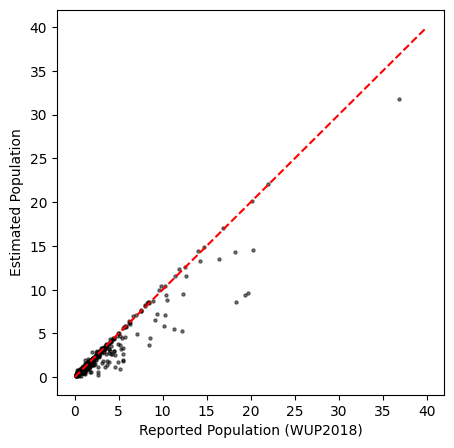

In [6]:
start = 0
end = 1553
stat = np.array(wup_list[start:end])
est = np.array(dwn_list[start:end])

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(stat, est, s=5, color='k', alpha=0.5)
#ax.set_xlim(0, 25)
#ax.set_ylim(0, 25)

# Add a y=x line
x = np.linspace(0, 40, 100)
ax.plot(x, x, color='red', linestyle='--')
ax.set_xlabel('Reported Population (WUP2018)')
ax.set_ylabel('Estimated Population')

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# 1. NRMSE (正規化された平均平方根誤差)
rmse = np.sqrt(mean_squared_error(stat, est))
nrmse = rmse / (stat.max() - stat.min())

# 2. PBIAS (パーセントバイアス)
pbias = 100 * np.sum(est - stat) / np.sum(stat)

# 3. R² (決定係数)
r2 = r2_score(stat, est)

# 4. NSE (ナッシュ-サトクリフ効率)
nse = 1 - (np.sum((stat - est) ** 2) / np.sum((stat - np.mean(stat)) ** 2))

# 5. KGE (クリング-グプタ効率)
cc = np.corrcoef(stat, est)[0, 1]  # 相関係数
alpha = np.std(est) / np.std(stat)  # 標準偏差の比率
beta = np.mean(est) / np.mean(stat) # 平均の比率
kge = 1 - np.sqrt((cc - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

# 結果を表示
print(f'NRMSE: {nrmse}')
print(f'PBIAS: {pbias}')
print(f'R²: {r2}')
print(f'NSE: {nse}')
print(f'KGE: {kge}')


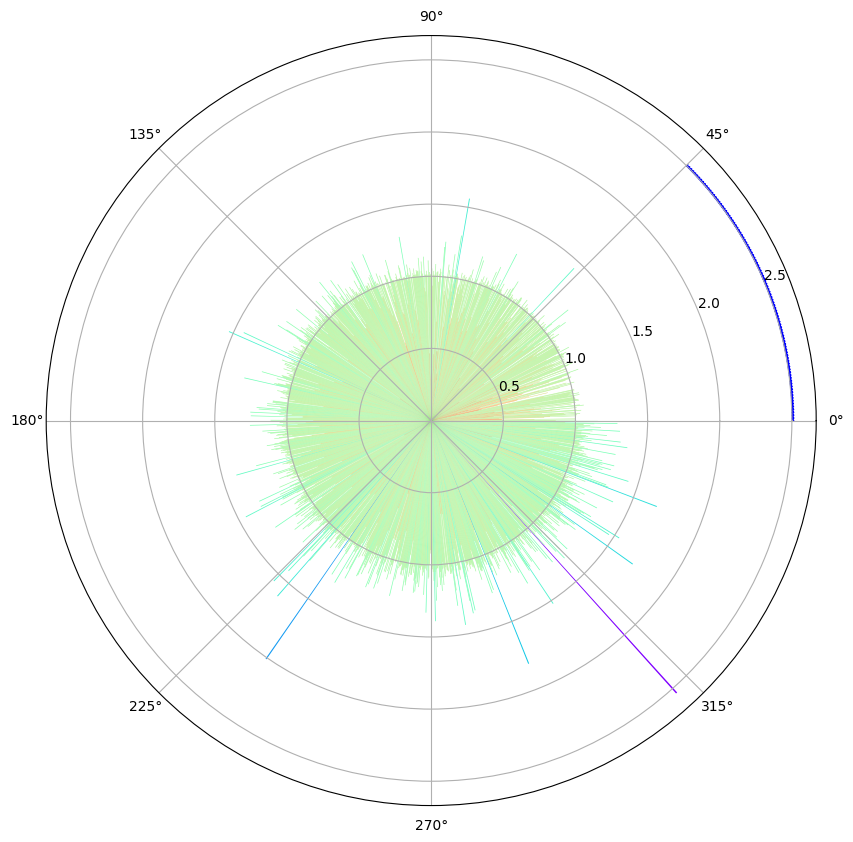

In [4]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'polar': True})

length = 1553
data = coverage_list[:length]
colors = plt.cm.rainbow_r(data / np.max(data))
angles = np.linspace(0, 2 * np.pi,  length, endpoint=False)
bars = ax.bar(angles, data, width=2 * np.pi / length, 
              bottom=0, color=colors, alpha=1.0)

# Define the angles and radii
theta = np.linspace(0, np.pi/4, 100)  # 0 to 45 degrees
r = np.linspace(2.5, 2.51, 1000)        # Radius greater than 2.5 (adjust as needed)
r, theta = np.meshgrid(r, theta)
ax.fill_between(theta.flatten(), 2.5, r.flatten(), color='blue')

# ticks
#ax.set_xticks([])  # X軸の目盛りを非表示
#ax.set_yticks([])  # Y軸の目盛りを非表示

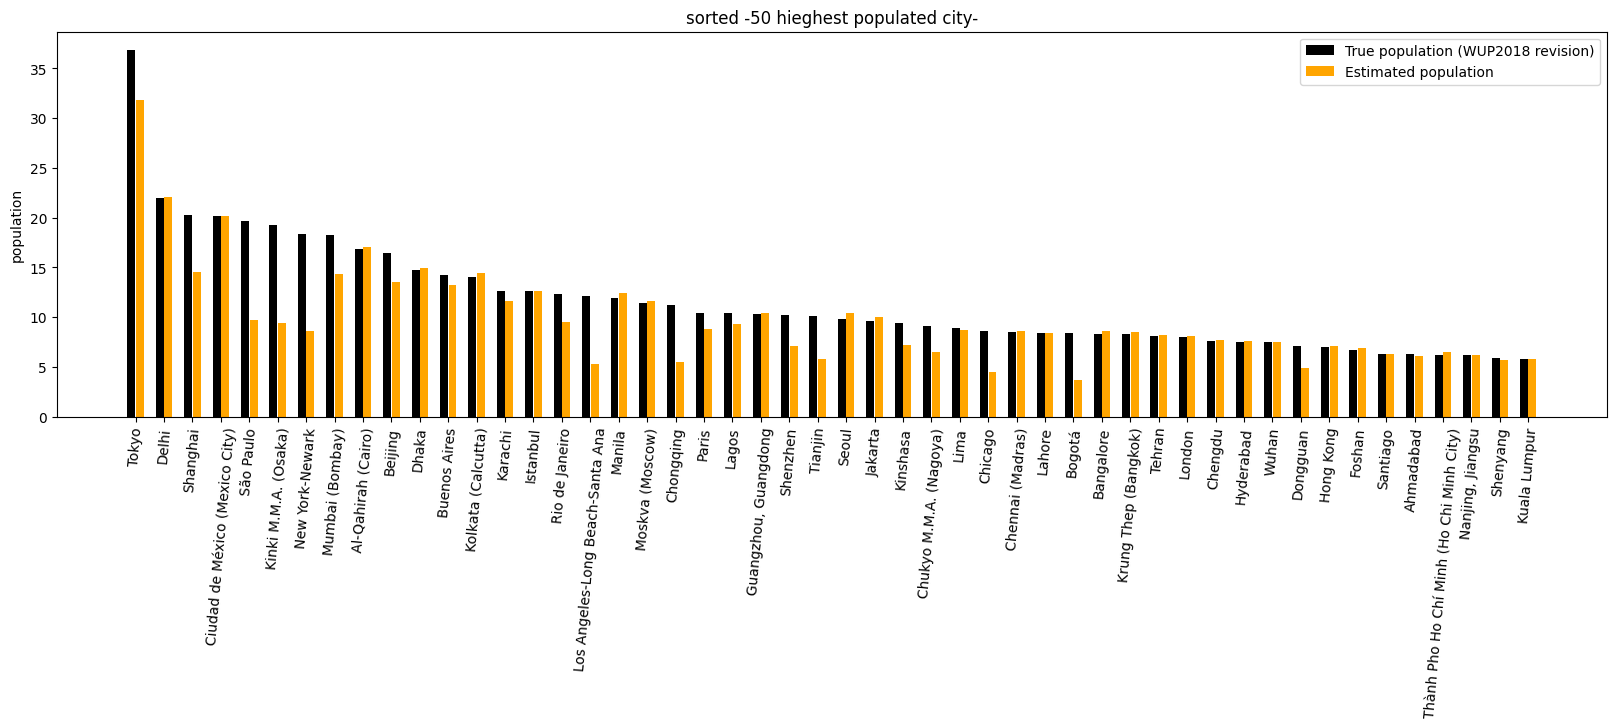

In [5]:
start = 0
end = 50

fig, ax = plt.subplots(figsize=(20, 5))
x = np.arange(end)
gap = 0.15
width=0.28
ax.bar(x-gap, wup_list[start:end], width, label='True population (WUP2018 revision)', color='black')
ax.bar(x+gap, dwn_list[start:end], width, label='Estimated population', color='orange')
ax.set_xticks(x)
ax.set_xticklabels(nam_list[start:end], fontsize=10, rotation=85)
ax.set_ylabel('population')
ax.set_title('sorted -50 hieghest populated city-')
ax.legend()